# Efficient epidemic state representation algorithm

## Load modules

In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/julia_codes/SmallCouplingDynamicCavity`


In [2]:
using SmallCouplingDynamicCavity
using Plots, LaTeXStrings
using Graphs, GraphRecipes
using Distributions
using SparseArrays

[ Info: Precompiling SmallCouplingDynamicCavity [1607259e-80f4-4675-b495-cb9c54bacb3f]
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



## Graph generation

In [3]:
NV = 100 # number of graph vertices
k = 3 # degree

# generate a random graph with NV vertices and NE edges
G = random_regular_graph(NV, k)

{100, 150} undirected simple Int64 graph

## - SI:

### System parameter definition and simulation

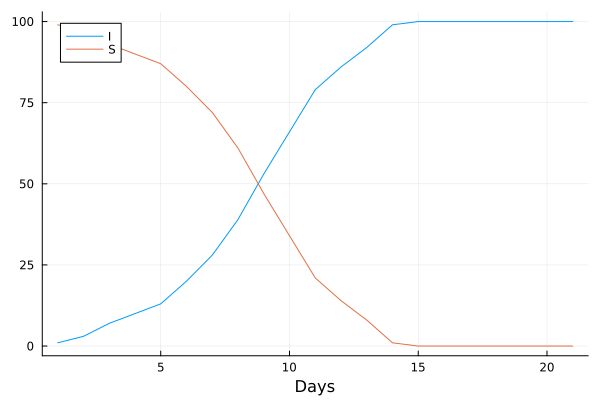

In [4]:
# define the constants
T::Int = 20 # total time
fₚ::Float64 = 0.0 # false-positive rate
fₙ::Float64 = 0.0 # false-negative rate
γ::Float64 = 1/NV # Patient zero probability
λ₀::Float64 = 0.5 # Infection rate
ε_autoinf::Float64 = 1e-10 # Self-infection rate
Nobs::Int = ceil(NV*.75) # Number of observations

# define the observation probability
function obsprob(Ob::Float64, x::Float64; fₚ::Float64 = fₚ, fₙ::Float64 = fₙ)
    if Ob == 0.0
        return (1-fₚ)*(1-x) + fₙ*x
    elseif  Ob == 1.0
        return fₚ*(1-x) + (1-fₙ)*x
    elseif Ob == -1.0
        return 1.0
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SI(ε_autoinf, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# epidemic simulation
config = sim_epidemics(model, patient_zero=[1])

# generate observations at the last time
obsmat = ones(nv(G), T+1) * (-1.0)
for (iₗ, τₗ) in zip(rand(1:nv(G), Nobs), rand(ceil(Int,T/2):T+1, Nobs))
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
end

isource = findall(x->x==1.0, config[:,1])

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
plot([nrI nrS], xlabel = "Days", ylabel = "", label = ["I" "S"])

### Inference

In [5]:
# computational constants
epsconv::Float64 = 5e-15 # convergence threshold
maxiter::Int = 5e2 # max number of iterations
damp::Float64 = 0.0 # damping factor
μ_cutoff::Float64 = -1

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

patient_zero_prob = [node.marg.m[2,1] for node in nodes]

println("source: $(isource[1])")
plot(patient_zero_prob, xlabel = "individual", ylabel = "posterior patient zero probability", label = "")

LoadError: MethodError: no method matching run_SCDC(::EpidemicModel{SI}, ::typeof(obsprob), ::Float64, ::Int64, ::Float64, ::Float64; μ_cutoff::Float64, callback::typeof(report))

[0mClosest candidates are:
[0m  run_SCDC(::EpidemicModel{TI}, ::Function, ::Float64, ::Int64, ::Float64, ::Float64) where TI<:SmallCouplingDynamicCavity.InfectionModel[91m got unsupported keyword arguments "μ_cutoff", "callback"[39m
[0m[90m   @[39m [35mSmallCouplingDynamicCavity[39m [90m~/julia_codes/SmallCouplingDynamicCavity/src/[39m[90m[4mmessage_passing_func.jl:234[24m[39m
[0m  run_SCDC(::EpidemicModel{TI}, ::Function, ::Float64, ::Int64, ::Float64, ::Float64, [91m::Float64[39m) where TI<:SmallCouplingDynamicCavity.InfectionModel[91m got unsupported keyword arguments "μ_cutoff", "callback"[39m
[0m[90m   @[39m [35mSmallCouplingDynamicCavity[39m [90m~/julia_codes/SmallCouplingDynamicCavity/src/[39m[90m[4mmessage_passing_func.jl:234[24m[39m
[0m  run_SCDC(::EpidemicModel{TI}, ::Function, ::Float64, ::Int64, ::Float64, ::Float64, [91m::Float64[39m, [91m::Function[39m) where TI<:SmallCouplingDynamicCavity.InfectionModel[91m got unsupported keyword arguments "μ_cutoff", "callback"[39m
[0m[90m   @[39m [35mSmallCouplingDynamicCavity[39m [90m~/julia_codes/SmallCouplingDynamicCavity/src/[39m[90m[4mmessage_passing_func.jl:234[24m[39m


## - SIS:

### System parameter definition and simulation

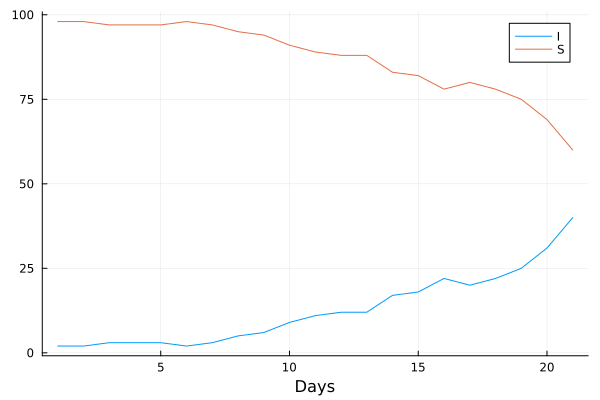

In [20]:
# define the constants
const T::Int = 20 # total time
const fₚ::Float64 = 0.0 # false-positive rate
const fₙ::Float64 = 0.0 # false-negative rate
const γ::Float64 = 1/NV # Patient zero probability
const λ₀::Float64 = 0.2 # Infection rate
const r₀::Float64 = 0.1 # Recovery rate
const Nobs::Int = ceil(NV*.75) # Number of observations

# define the observation probability
function obsprob(Ob::Float64, x::Float64; fₚ::Float64 = fₚ, fₙ::Float64 = fₙ)
    if Ob == 0.0
        return (1-fₚ)*(1-x) + fₙ*x
    elseif  Ob == 1.0
        return fₚ*(1-x) + (1-fₙ)*x
    elseif Ob == -1.0
        return 1.0
    end
end

# randomly generate the infection probability Matrix
#λ = zeros(NV, NV, T+1)
#for e in edges(G)
#    λ[src(e), dst(e), :] = rand(T+1)
#    λ[dst(e), src(e), :] = rand(T+1)
#end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# constant recovery rate
r = ones(NV, T+1).*r₀

# epidemic simulation
config = sim_epidemics(G, log.(1 .- λ), T, :SIS, r = r, γ=γ)

# generate observations at the last time
obsmat = ones(nv(G), T+1) * (-1.0)
for (iₗ, τₗ) in zip(rand(1:nv(G), Nobs), rand(Int(T/2):T+1, Nobs))
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
end

isource = findall(x->x==1.0, config[:,1])

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
plot([nrI nrS], xlabel = "Days", ylabel = "", label = ["I" "S"])

### Inference

i = 1 ε = 1.091086439089064
i = 2 ε = 1.6305182131101232
i = 3 ε = 1.4222837107071329
i = 4 ε = 1.0456522046268908
i = 5 ε = 0.7045104814883775
i = 6 ε = 0.4114032225593307
i = 7 ε = 0.33502402405156695
i = 8 ε = 0.46919046739535697
i = 9 ε = 0.16624146441760684
i = 10 ε = 0.07490161069132029


i = 11 ε = 0.09938728899073712
i = 12 ε = 0.02655815361672076
i = 13 ε = 0.014160688482489858
i = 14 ε = 0.024975321326876743
i = 15 ε = 0.008851361557522752
i = 16 ε = 0.004356299260287688
i = 17 ε = 0.007677640007480835
i = 18 ε = 0.0026905611711971478
i = 19 ε = 0.001789330195201111
i = 20 ε = 0.0021108260690982927
i = 21 ε = 0.0008425146124911853
i = 22 ε = 0.00040290477607940467
i = 23 ε = 0.0005893950436515194
i = 24 ε = 0.0002449150481246276
i = 25 ε = 0.00010164846160065633
i = 26 ε = 0.00015853681420752164
i = 27 ε = 7.237768921797283e-5
i = 28 ε = 3.120122192434849e-5
i = 29 ε = 4.418663454242022e-5
i = 30 ε = 2.2347030036562465e-5
i = 31 ε = 9.44264170144038e-6
i = 32 ε = 1.2430909844818316e-5
i = 33 ε = 6.4844466962643565e-6
i = 34 ε = 2.6095735929931863e-6
i = 35 ε = 3.386135534411139e-6
i = 36 ε = 1.8935636028061253e-6
i = 37 ε = 7.146752224462816e-7
i = 38 ε = 9.333109929343664e-7
i = 39 ε = 5.565203323731893e-7
i = 40 ε = 2.0521624444214126e-7
i = 41 ε = 2.5666038938609

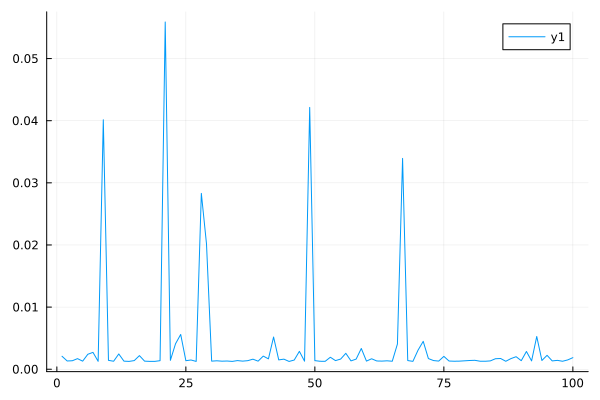

In [23]:
# computational constants
const epsconv::Float64 = 5e-13 # convergence threshold
const maxiter::Int = 5e2 # max number of iterations
const damp::Float64 = 0.0 # damping factor
const μ_cutoff::Float64 = -1
const ε_autoinf::Float64 = 1e-10

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(G, λ, obsmat, obsprob, γ, T, maxiter, epsconv, damp, :SIS, r =r, callback = report, μ_cutoff = μ_cutoff, ε_autoinf = ε_autoinf);

patient_zero_prob = [node.marg.m[2,1] for node in nodes]

println("source: $(isource[1])")
plot(patient_zero_prob)

## - SIR:

### System parameter definition and simulation

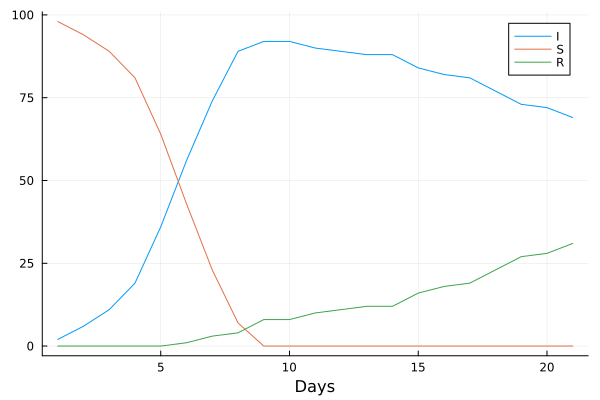

In [35]:
# define the constants
const T::Int = 20 # total time
const fₚ::Float64 = 0.0 # false-positive rate
const fₙ::Float64 = 0.0 # false-negative rate
const γ::Float64 = 1/NV # Patient zero probability
const λ₀::Float64 = 0.15 # Infection rate
const r₀::Float64 = 0.02 # Recovery rate
const Nobs::Int = ceil(NV*.75) # Number of observations

# define the observation probability
function obsprob(Ob::Float64, x::Float64)
    if Ob == -1.0
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# randomly generate the infection probability Matrix
#λ = zeros(NV, NV, T+1)
#for e in edges(G)
#    λ[src(e), dst(e), :] = rand(T+1)
#    λ[dst(e), src(e), :] = rand(T+1)
#end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# constant recovery rate
r = ones(NV, T+1).*r₀

# epidemic simulation
config = sim_epidemics(G, log.(1 .- λ), T, :SIR, r = r, γ=γ)

# generate observations at the last time
obsmat = ones(nv(G), T+1) * (-1.0)
for (iₗ, τₗ) in zip(rand(1:nv(G), Nobs), rand(Int(T/2):T+1, Nobs))
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
end

isource = findall(x->x==1.0, config[:,1])

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)
plot([nrI nrS nrR], xlabel = "Days", ylabel = "", label = ["I" "S" "R"])

### Inference

i = 1 ε = 1.0
i = 2 ε = 1.0764910908238021
i = 3 ε = 1.0837265763532657
i = 4 ε = 1.0862734648800634
i = 5 ε = 0.3343697149517175
i = 6 ε = 0.2647732863309638
i = 7 ε = 0.148842640028714
i = 8 ε = 0.05440096340201972
i = 9 ε = 0.026459121314114264
i = 10 ε = 0.01969265637789952
i = 11 ε = 0.010691548888390134
i = 12 ε = 0.004912201070619182
i = 13 ε = 0.004384706972206498
i = 14 ε = 0.0032653290649718447
i = 15 ε = 0.0019799584682023974
i = 16 ε = 0.0007093747086564239
i = 17 ε = 0.0006046321708803593
i = 18 ε = 0.000498876313003771
i = 19 ε = 0.00032208064575953155
i = 20 ε = 0.00015856555228407898
i = 21 ε = 8.23179656349593e-5
i = 22 ε = 6.951656308215592e-5
i = 23 ε = 5.009195594285476e-5
i = 24 ε = 2.982858237790542e-5
i = 25 ε = 1.1041702158209876e-5
i = 26 ε = 9.777667998228656e-6
i = 27 ε = 7.906101610055671e-6
i = 28 ε = 5.013710939333338e-6
i = 29 ε = 2.2856571256224534e-6
i = 30 ε = 1.3461663593838935e-6
i = 31 ε = 1.129814777733884e-6
i = 32 ε = 7.652186591600163e-7
i = 33 

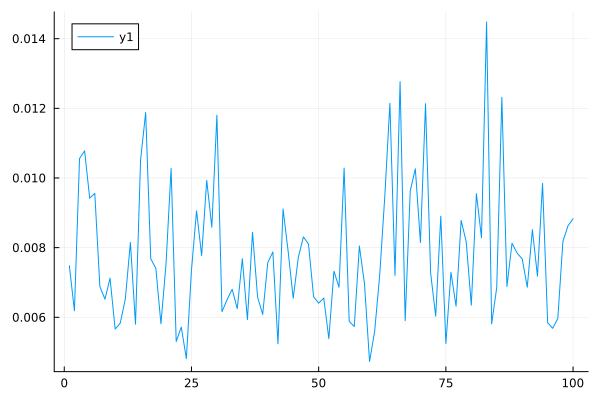

In [36]:
# computational constants
const epsconv::Float64 = 5e-13 # convergence threshold
const maxiter::Int = 5e2 # max number of iterations
const damp::Float64 = 0.0 # damping factor
const μ_cutoff::Float64 = -1
const ε_autoinf::Float64 = 1e-10

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(G, λ, obsmat, obsprob, γ, T, maxiter, epsconv, damp, :SIR, r =r, callback = report, μ_cutoff = μ_cutoff, ε_autoinf = ε_autoinf);

patient_zero_prob = [node.marg.m[2,1] for node in nodes]

println("source: $(isource[1])")
plot(patient_zero_prob)

## - SIRS:

### System parameter definition and simulation

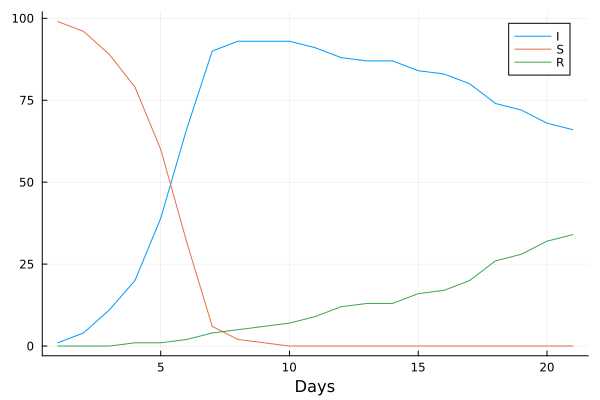

In [42]:
NV = 100 # number of graph vertices
k = 10 # degree

# generate a random graph with NV vertices and NE edges
G = random_regular_graph(NV, k)

# define the constants
const T::Int = 20 # total time
const fₚ::Float64 = 0.0 # false-positive rate
const fₙ::Float64 = 0.0 # false-negative rate
const γ::Float64 = 1/NV # Patient zero probability
const λ₀::Float64 = 0.2 # Infection rate
const r₀::Float64 = 0.02 # Recovery rate
const σ₀::Float64 = 0.02 # Immunity rate
const Nobs::Int = 500 # Number of observations

# define the observation probability
function obsprob(Ob::Float64, x::Float64)
    if Ob == -1.0
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# randomly generate the infection probability Matrix
#λ = zeros(NV, NV, T+1)
#for e in edges(G)
#    λ[src(e), dst(e), :] = rand(T+1)
#    λ[dst(e), src(e), :] = rand(T+1)
#end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# constant recovery rate
r = ones(NV, T+1).*r₀

# constant immunity rate
σ = ones(NV, T+1).*σ₀

# epidemic simulation
config = sim_epidemics(G, log.(1 .- λ), T, :SIR, r = r, σ=σ, γ=γ)

# generate observations at the last time
obsmat = ones(nv(G), T+1) * (-1.0)
for (iₗ, τₗ) in zip(rand(1:nv(G), Nobs), rand(Int(T/2):T+1, Nobs))
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
end

isource = findall(x->x==1.0, config[:,1])

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)
plot([nrI nrS nrR], xlabel = "Days", ylabel = "", label = ["I" "S" "R"])

### Inference

i = 1 ε = 1.0
i = 2 ε = 1.0025370663819468
i = 3 ε = 1.061313139592151
i = 4 ε = 1.01606310189463
i = 5 ε = 0.40034497562217697
i = 6 ε = 0.28727194455629074
i = 7 ε = 0.28927454902507727
i = 8 ε = 0.09808869800596065
i = 9 ε = 0.03910559101633282
i = 10 ε = 0.036509919120180534
i = 11 ε = 0.017332469392374872
i = 12 ε = 0.0052992296711334985
i = 13 ε = 0.005646223242468218
i = 14 ε = 0.003535125472652667
i = 15 ε = 0.0006446450861871122
i = 16 ε = 0.0008115997162477795
i = 17 ε = 0.0006559630524068938
i = 18 ε = 0.00016157370649394487
i = 19 ε = 0.0001321631494396458
i = 20 ε = 0.00011527505211827993
i = 21 ε = 4.090443096327334e-5
i = 22 ε = 2.029196998865057e-5
i = 23 ε = 1.9161310619408845e-5
i = 24 ε = 8.960145391645469e-6
i = 25 ε = 2.8652080644731015e-6
i = 26 ε = 2.9953166709173473e-6
i = 27 ε = 1.7960048069864953e-6
i = 28 ε = 3.5503058948282984e-7
i = 29 ε = 4.3353660617029277e-7
i = 30 ε = 3.3683644307114236e-7
i = 31 ε = 7.769052134953824e-8
i = 32 ε = 6.911803529519034e-8


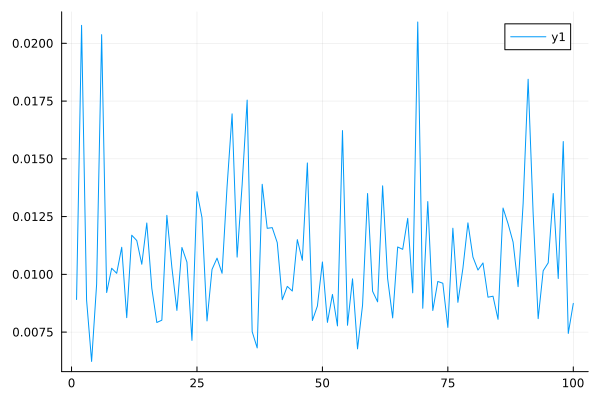

In [43]:
# computational constants
const epsconv::Float64 = 5e-13 # convergence threshold
const maxiter::Int = 5e2 # max number of iterations
const damp::Float64 = 0.0 # damping factor
const μ_cutoff::Float64 = -1
const ε_autoinf::Float64 = 1e-10

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(G, λ, obsmat, obsprob, γ, T, maxiter, epsconv, damp, :SIRS, r =r, σ=σ, callback = report, μ_cutoff = μ_cutoff, ε_autoinf = ε_autoinf);

patient_zero_prob = [node.marg.m[2,1] for node in nodes]

println("source: $(isource[1])")
plot(patient_zero_prob)